<a href="https://colab.research.google.com/github/weiling0325/Schizophrenia-Detection-Using-Microbiome-Data/blob/main/Approach_2_RFECV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Approach 2: Recursive feature elimination with cross-validation (RFECV)**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import pickle

# import warning library to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/training_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/testing_data.csv')

In [ ]:
X_train = train_df.drop(columns=['diagnosis'])
y_train = train_df['diagnosis']

X_test = test_df.drop(columns=['diagnosis'])
y_test = test_df['diagnosis']

In [ ]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Check if 'age' is among the selected features
if 'age' not in selected_features:
    # Manually add 'age' to the selected features if not already present
    selected_features = selected_features.tolist()
    selected_features.append('age')

print('Optimal number of features (including "age" if added): {}'.format(len(selected_features)))
print("Selected Features:", selected_features)

Optimal number of features (including "age" if added): 252
Selected Features: Index(['age', 'd__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter', 'd__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera', 'd__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Methanomassiliicoccus', 'd__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomethylophilaceae;__', 'd__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomethylophilaceae;g__uncultured', 'd__Bacteria;__;__;__;__;__', 'd__Bacteria;p__Actinobacteriota;__;__;__;__', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;__;__;__', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces',
       ...
       'd__Bacteria;p__Synergistota;c__Synergistia;o__Synerg

In [ ]:
# Create a new DataFrame with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the final RandomForestClassifier model using the selected features
new_rf = RandomForestClassifier(n_estimators=100, random_state=42)
new_rf.fit(X_train_selected, y_train)

# Evaluate the model accuracy on the test data
y_pred = new_rf.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Evaluate the model accuracy with 5-fold cross-validation on the training data
accuracy_scores = cross_val_score(new_rf, X_train_selected, y_train, cv=5, scoring='accuracy')

# Display the cross-validation results
print(f"Accuracy scores (5-fold CV): {accuracy_scores}")
print(f"Mean accuracy: {accuracy_scores.mean():.4f}")

Test Accuracy: 0.7755102040816326
Accuracy scores (5-fold CV): [0.7826087  0.7826087  1.         0.77272727 0.72727273]
Mean accuracy: 0.8130


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for RandomForestclassifier using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used
}
random_search = RandomizedSearchCV(estimator=new_rf, param_distributions=param_dist,cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model on the training data
random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f'Best hyperparameters: {best_params}')

# Train the model with the best hyperparameters
best_rf = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test_selected)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with tuned hyperparameters: {accuracy}')

# Evaluate the model accuracy with 5 fold cv
accuracy_scores = cross_val_score(best_rf, X_train_selected, y_train, cv=5, scoring='accuracy')

# Display the results for each metric
print(f"Accuracy scores (5-fold CV): {accuracy_scores}")
print(f"Mean accuracy: {accuracy_scores.mean():.4f}")


Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Accuracy with tuned hyperparameters: 0.7755102040816326
Accuracy scores (5-fold CV): [0.82608696 0.7826087  0.90909091 0.81818182 0.77272727]
Mean accuracy: 0.8217


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        24
           1       0.89      0.64      0.74        25

    accuracy                           0.78        49
   macro avg       0.80      0.78      0.77        49
weighted avg       0.80      0.78      0.77        49


Confusion Matrix:
[[22  2]
 [ 9 16]]



AUC-ROC Score: 0.8133


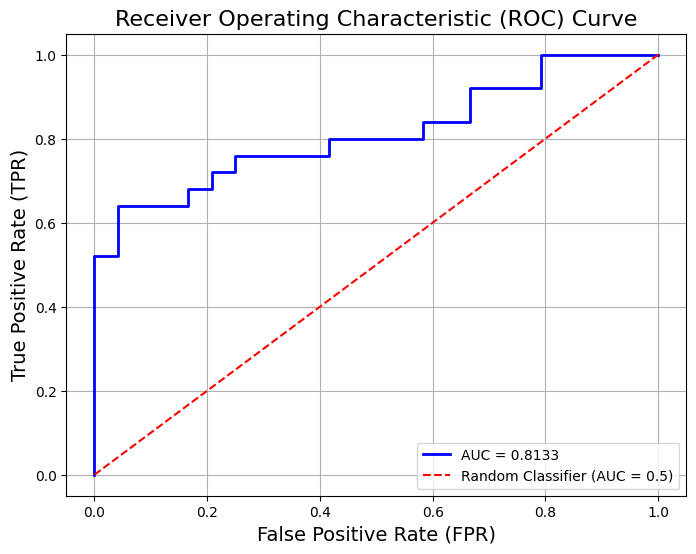

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_rf.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
###Logistic Regression
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
clf = LogisticRegression(random_state=42)

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
clf_rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='accuracy')
clf_rfecv.fit(X_train, y_train)

# Get the selected features
clf_selected_features = X_train.columns[clf_rfecv.support_]

# Check if 'age' is among the selected features
if 'age' not in clf_selected_features:
    # Manually add 'age' to the selected features if not already present
    clf_selected_features = clf_selected_features.tolist()
    clf_selected_features.append('age')

print('Optimal number of features (including "age" if added): {}'.format(len(clf_selected_features)))
print("Selected Features:", clf_selected_features)

# Create a new DataFrame with only the selected features
X_train_selected_clf = X_train[clf_selected_features]
X_test_selected_clf = X_test[clf_selected_features]

# Train final model using the selected features
new_clf = LogisticRegression(random_state=42)
new_clf.fit(X_train_selected_clf, y_train)

# Evaluate the model accuracy
y_pred = new_clf.predict(X_test_selected_clf)
clf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", clf_accuracy)

# Evaluate the model using 5-fold cross-validation with different scoring metrics
clf_accuracy_scores = cross_val_score(new_clf, X_train_selected_clf, y_train, cv=5, scoring='accuracy')

# Display the results for each metric
print(f"Accuracy scores (5-fold CV): {clf_accuracy_scores}")
print(f"Mean accuracy: {clf_accuracy_scores.mean():.4f}")


Optimal number of features (including "age" if added): 295
Selected Features: ['d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera', 'd__Bacteria;__;__;__;__;__', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;__;__;__', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinotignum', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__F0332', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Corynebacteriales;

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for LogisticRegression using RandomizedSearchCV
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization penalty
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}
clf_random_search = RandomizedSearchCV(estimator=new_clf, param_distributions=param_dist, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model on the training data
clf_random_search.fit(X_train_selected_clf, y_train)

# Get the best hyperparameters
clf_best_params = clf_random_search.best_params_
print(f'Best hyperparameters: {clf_best_params}')

# Train the model with the best hyperparameters
best_clf = clf_random_search.best_estimator_

# Make predictions on the test set
y_pred = best_clf.predict(X_test_selected_clf)

# Evaluate the model performance
clf_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with tuned hyperparameters: {clf_accuracy}')

# Evaluate the model accuracy with 5 fold cv
clf_accuracy_scores = cross_val_score(best_clf, X_train_selected_clf, y_train, cv=5, scoring='accuracy')

# Display the results for each metric
print(f"Accuracy scores (5-fold CV): {clf_accuracy_scores}")
print(f"Mean accuracy: {clf_accuracy_scores.mean():.4f}")

Best hyperparameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'C': 10}
Accuracy with tuned hyperparameters: 0.7755102040816326
Accuracy scores (5-fold CV): [0.73913043 0.7826087  0.95454545 0.68181818 0.72727273]
Mean accuracy: 0.7771


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       0.79      0.76      0.78        25

    accuracy                           0.78        49
   macro avg       0.78      0.78      0.78        49
weighted avg       0.78      0.78      0.78        49


Confusion Matrix:
[[19  5]
 [ 6 19]]



AUC-ROC Score: 0.8317


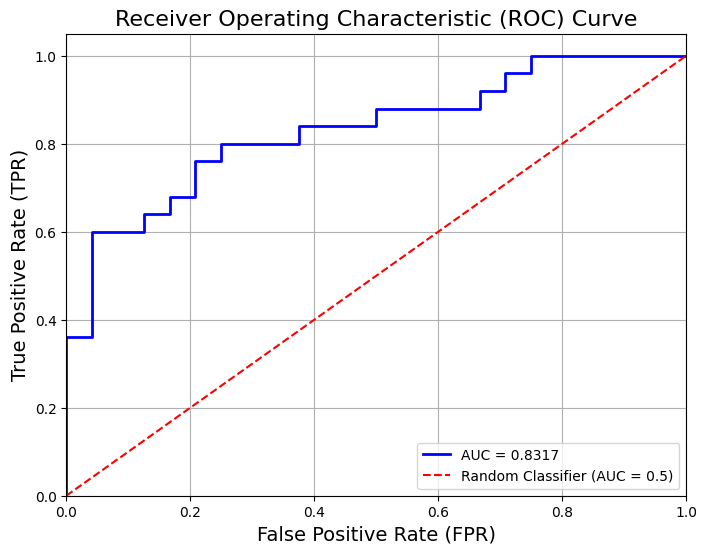

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_clf.predict_proba(X_test_selected_clf)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()



**SMOTE Technique With RandomForestclassifier**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Ensure 'age' is among the selected features
if 'age' not in selected_features:
    selected_features = selected_features.tolist()
    selected_features.append('age')

print('Optimal number of features (including "age" if added): {}'.format(len(selected_features)))
print("Selected Features:", selected_features)

# Create new DataFrames with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Define the pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the Random Forest model using the selected features
pipeline.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test_selected)
accuracy_before_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (before tuning): {accuracy_before_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation
cv_accuracy_before = cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (before tuning): {cv_accuracy_before}")
print(f"Mean CV Accuracy (before tuning): {cv_accuracy_before.mean():.4f}")

Optimal number of features (including "age" if added): 252
Selected Features: Index(['age', 'd__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter', 'd__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera', 'd__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Methanomassiliicoccus', 'd__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomethylophilaceae;__', 'd__Archaea;p__Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomethylophilaceae;g__uncultured', 'd__Bacteria;__;__;__;__;__', 'd__Bacteria;p__Actinobacteriota;__;__;__;__', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;__;__;__', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces',
       ...
       'd__Bacteria;p__Synergistota;c__Synergistia;o__Synerg

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79        24
           1       0.85      0.68      0.76        25

    accuracy                           0.78        49
   macro avg       0.79      0.78      0.77        49
weighted avg       0.79      0.78      0.77        49


Confusion Matrix:
[[21  3]
 [ 8 17]]



AUC-ROC Score: 0.7883


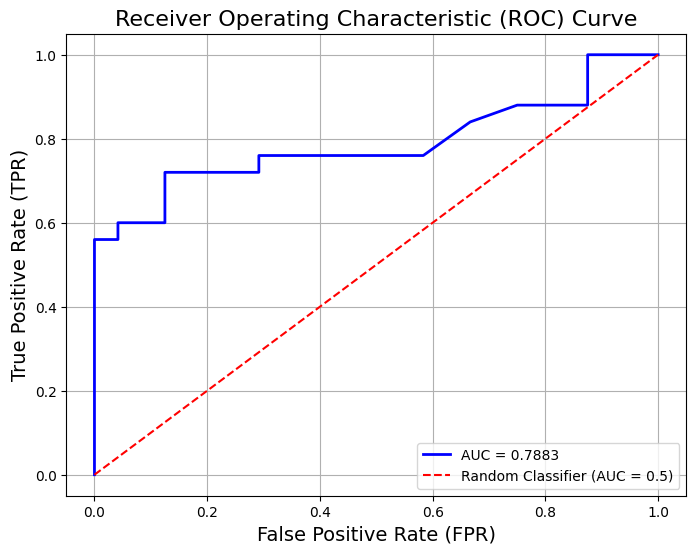

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for RandomForestclassifier using RandomizedSearchCV
param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f'Best hyperparameters: {best_params}')

# Train the model with the best hyperparameters
best_pipeline = random_search.best_estimator_

# Evaluate the tuned model on the test set
y_pred = best_pipeline.predict(X_test_selected)
accuracy_after_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (after tuning): {accuracy_after_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation after tuning
cv_accuracy_after = cross_val_score(best_pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (after tuning): {cv_accuracy_after}")
print(f"Mean CV Accuracy (after tuning): {cv_accuracy_after.mean():.4f}")

Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': None, 'rf__bootstrap': False}
Test Accuracy (after tuning): 0.7551
5-Fold CV Accuracy (after tuning): [0.82608696 0.7826087  0.90909091 0.77272727 0.77272727]
Mean CV Accuracy (after tuning): 0.8126


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        24
           1       0.84      0.64      0.73        25

    accuracy                           0.76        49
   macro avg       0.77      0.76      0.75        49
weighted avg       0.77      0.76      0.75        49


Confusion Matrix:
[[21  3]
 [ 9 16]]



AUC-ROC Score: 0.8283


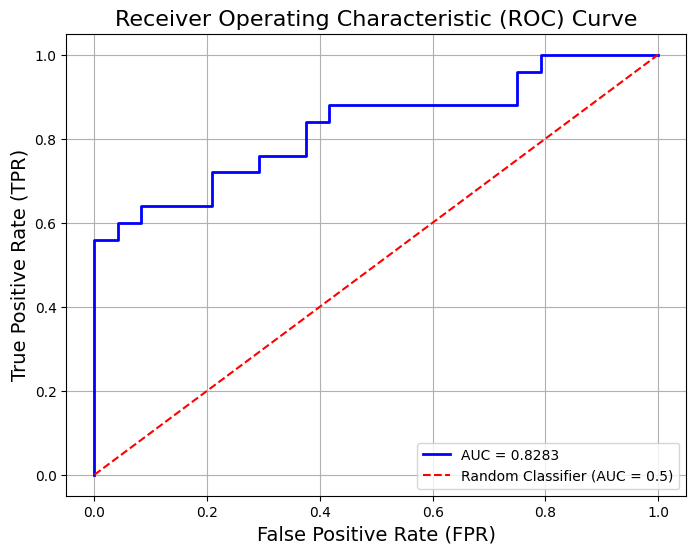

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

**SMOTE Technique With LogisticRegression**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Initialize the Random Forest classifier
clf = LogisticRegression(random_state=42)

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Ensure 'age' is among the selected features
if 'age' not in selected_features:
    selected_features = selected_features.tolist()
    selected_features.append('age')

print('Optimal number of features (including "age" if added): {}'.format(len(selected_features)))
print("Selected Features:", selected_features)

# Create new DataFrames with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Define the pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(random_state=42))
])

# Train the Random Forest model using the selected features
pipeline.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test_selected)
accuracy_before_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (before tuning): {accuracy_before_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation
cv_accuracy_before = cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (before tuning): {cv_accuracy_before}")
print(f"Mean CV Accuracy (before tuning): {cv_accuracy_before.mean():.4f}")


Optimal number of features (including "age" if added): 295
Selected Features: ['d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera', 'd__Bacteria;__;__;__;__;__', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;__;__;__', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinotignum', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__F0332', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Corynebacteriales;

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.81      0.68      0.74        25

    accuracy                           0.76        49
   macro avg       0.76      0.76      0.75        49
weighted avg       0.76      0.76      0.75        49


Confusion Matrix:
[[20  4]
 [ 8 17]]



AUC-ROC Score: 0.8250


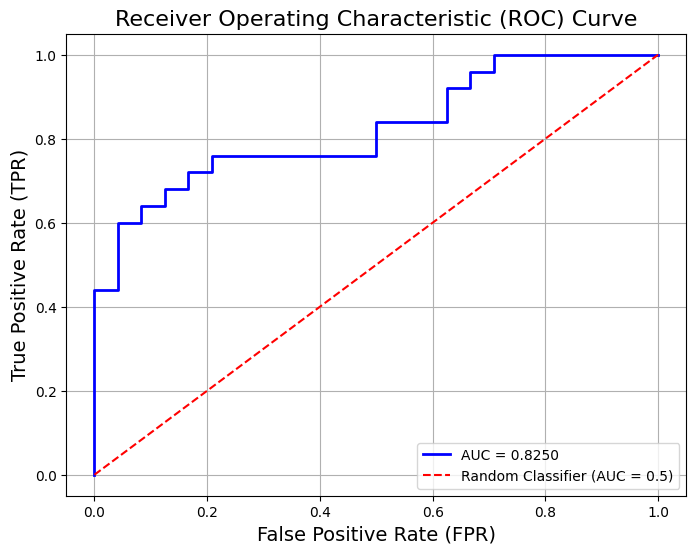

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for LogisticRegression using RandomizedSearchCV
param_dist = {
    'clf__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization penalty
    'clf__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'clf__solver': ['lbfgs', 'liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'clf__max_iter': [100, 200, 300]  # Maximum number of iterations
}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f'Best hyperparameters: {best_params}')

# Train the model with the best hyperparameters
best_pipeline = random_search.best_estimator_

# Evaluate the tuned model on the test set
y_pred = best_pipeline.predict(X_test_selected)
accuracy_after_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (after tuning): {accuracy_after_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation after tuning
cv_accuracy_after = cross_val_score(best_pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (after tuning): {cv_accuracy_after}")
print(f"Mean CV Accuracy (after tuning): {cv_accuracy_after.mean():.4f}")

Best hyperparameters: {'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__max_iter': 100, 'clf__C': 10}
Test Accuracy (after tuning): 0.7347
5-Fold CV Accuracy (after tuning): [0.7826087  0.73913043 0.90909091 0.68181818 0.86363636]
Mean CV Accuracy (after tuning): 0.7953


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71        24
           1       0.71      0.80      0.75        25

    accuracy                           0.73        49
   macro avg       0.74      0.73      0.73        49
weighted avg       0.74      0.73      0.73        49


Confusion Matrix:
[[16  8]
 [ 5 20]]



AUC-ROC Score: 0.8333


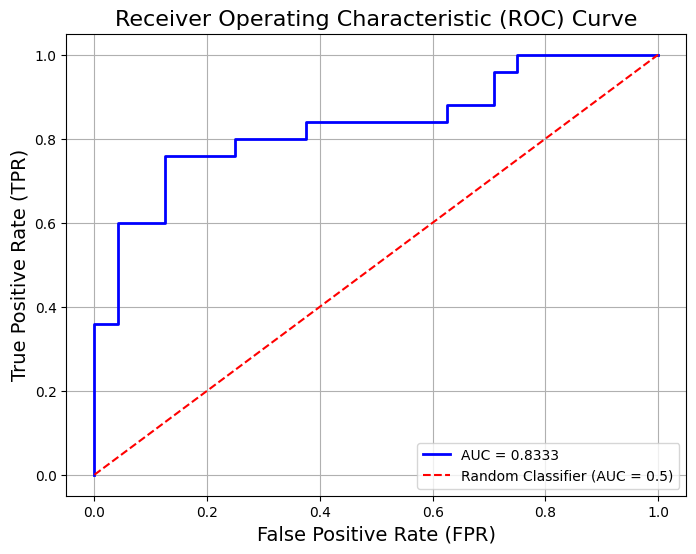

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()